In [1]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
# 定数定義
CANNY_WINDOW_NAME = "canny"
ORG_FILE_NAME = "IMG_9159.JPG"
CANNY_FILE_NAME = "canny.png"
# 元の画像を読み込む
org_img = cv2.imread(ORG_FILE_NAME, cv2.IMREAD_UNCHANGED)
# グレースケールに変換
gray_img = cv2.imread(ORG_FILE_NAME, cv2.IMREAD_GRAYSCALE)
# エッジ抽出
canny_img = cv2.Canny(gray_img, 50, 110)
# ファイルに保存
cv2.imwrite(CANNY_FILE_NAME, canny_img)

True

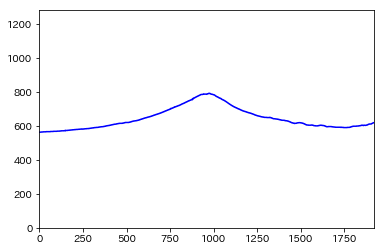

In [3]:
# 画像から数値を抽出
ns = []
max_height = canny_img.shape[0]
for i, c in enumerate(canny_img.T):
    flg = True
    ns.append(max_height - np.argmax(c))#座標反転用(転置すると上下反転していた)
ns = np.array(ns)
offset = ns.min()
fujiyama = ns - offset #山の稜線を出す。
plt.xlim(0,1920)
plt.ylim(0,1280)
plt.plot(ns,color="blue")
# データ配列用に並べ替える
sample = []
for i,n in enumerate(fujiyama):
    sample_ = [i]*n
    sample.extend(sample_)
sample = np.array(sample)

## t分布とEMアルゴリズム

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, digamma


class Gaussian(object):
    """
    fit : ハイパーパラメータ(mean, sigma)の調整だけでOK
    predict : 正規分布
    """
    def fit(self, x):
        self.mu = np.array(x).mean()
        self.sigma = np.array(x).std()
    
    def predict(self, x):
        return 1/np.sqrt(2*np.pi*self.sigma**2)*(np.exp(-(x-self.mu)**2/(2*self.sigma**2)))
    
class RobustGaussian(object):
    """
    平均の代わりにmedianを使う
    """
    def fit(self, x):
        self.mu = np.median(np.array(x))
        self.sigma = np.sqrt(np.dot(np.array(x)- self.mu, np.array(x)-self.mu)/len(x))

    def predict(self,x):
        return 1/np.sqrt(2*np.pi*self.sigma**2)*(np.exp(-(x-self.mu)**2/(2*self.sigma**2)))

class StudentsT(object):

    def __init__(self, mu=0, sigma=1, nu=1, iteration=10, solve_nu=False):
        self.mu = mu
        self.sigma = sigma
        self.nu = nu
        self.iteration = iteration
        self.solve_nu = solve_nu
        
    def fit(self, x, N):
        # E
        self.n = len(x)
        for _ in range(N):
            self.w = (self.nu+1)/(self.nu+(x-self.mu)**2/self.sigma)
            # M
            self.mu = np.sum(self.w*x)/np.sum(self.w)
            self.sigma = 1/self.n*(np.sum(self.w*(x-self.mu)*(x-self.mu)))
            # nuを求める(二分法)
            if self.solve_nu:
                _a = 1
                _b = 3
                for i in range(self.iteration):
                    _x = (_a+_b)/2.0 # 中点を出す  
                    if self._expect_nu(_a)*self._expect_nu(_x) < 0:
                        _b = _x
                    if self._expect_nu(_b)*self._expect_nu(_x) < 0:
                        _a = _x
                self.nu = _x
    
    def _expect_nu(self, nu):
        """
        最尤推定でnuを求めるときの方程式
        """
        x = -digamma(nu/2)+np.log(nu/2)
        a1 = 1/self.n*np.sum(np.log(self.w)-self.w)+1
        a2 = digamma(self.nu/2+1/2)-np.log(self.nu/2+1/2)
        return x+a1+a2
    
    def predict(self, x):
        return (1/np.sqrt(np.pi*self.nu*self.sigma))*gamma((self.nu+1)/2)/gamma(self.nu/2)*np.power(1+1/(self.nu*self.sigma)*(x-self.mu)**2,-(self.nu+1)/2)




plot x sample
Fit Gaussian
Fit Robust Gaussian
Fit Students T Distribution
1.0072798122065727 0.979


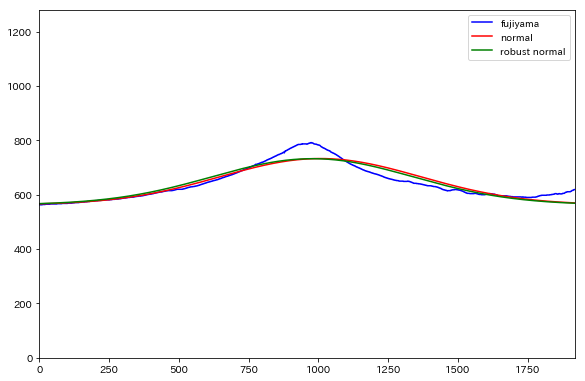

In [5]:
f =1000 #縮小率
data = sample/f
print("plot x sample")
# prepare model
students_t = StudentsT(nu=1)
gaussian = Gaussian()
gaussian_robust = RobustGaussian()
# maximum likelihood estimate
gaussian.fit(data)
print("Fit Gaussian")
gaussian_robust.fit(data)
print("Fit Robust Gaussian")
students_t.fit(data,100)
print("Fit Students T Distribution")

print(gaussian.mu, gaussian_robust.mu)

# plot results
x = np.linspace(0, 1920/f, 1920)
# 補正 : x方向にはf倍(圧縮の都合)。y座標は1/f(正規化の都合)*元データのスケールに合わせる
fujiyama_student = students_t.predict(x)/f*fujiyama.sum()+offset
fujiyama_gaussian = gaussian.predict(x)/f*fujiyama.sum()+offset
fujiyama_robust = gaussian_robust.predict(x)/f*fujiyama.sum()+offset

# plot
plt.figure(figsize=(9.6,6.4))
plt.plot(ns,color="blue",label="fujiyama") #富士山関数を正規化
# plt.plot(x*f,fujiyama_student, label="students t",color="orange")
plt.plot(x*f,fujiyama_gaussian, label="normal",color="red")
plt.plot(x*f,fujiyama_robust, label="robust normal",color="green")

plt.xlim(0,1920)
plt.ylim(0,1280)
plt.legend()
plt.savefig("fitting.png",transparent=True)


plot x sample
Fit Gaussian
Fit Robust Gaussian
Fit Students T Distribution
1.0072798122065727 0.979


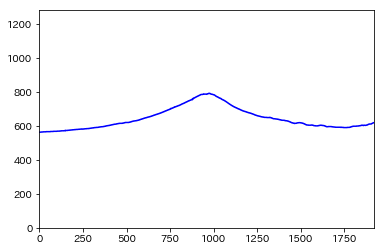

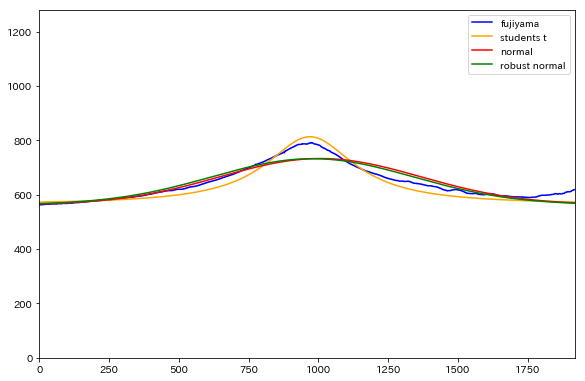

In [6]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
# 定数定義
CANNY_WINDOW_NAME = "canny"
ORG_FILE_NAME = "IMG_9159.JPG"
CANNY_FILE_NAME = "canny.png"
# 元の画像を読み込む
org_img = cv2.imread(ORG_FILE_NAME, cv2.IMREAD_UNCHANGED)
# グレースケールに変換
gray_img = cv2.imread(ORG_FILE_NAME, cv2.IMREAD_GRAYSCALE)
# エッジ抽出
canny_img = cv2.Canny(gray_img, 50, 110)
# ファイルに保存
cv2.imwrite(CANNY_FILE_NAME, canny_img)
# 画像から数値を抽出
ns = []
max_height = canny_img.shape[0]
for i, c in enumerate(canny_img.T):
    flg = True
    ns.append(max_height - np.argmax(c))#座標反転用(転置すると上下反転していた)
ns = np.array(ns)
offset = ns.min()
fujiyama = ns - offset #山の稜線を出す。
plt.xlim(0,1920)
plt.ylim(0,1280)
plt.plot(ns,color="blue")
# データ配列用に並べ替える
sample = []
for i,n in enumerate(fujiyama):
    sample_ = [i]*n
    sample.extend(sample_)
sample = np.array(sample)
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, digamma


class Gaussian(object):
    """
    fit : ハイパーパラメータ(mean, sigma)の調整だけでOK
    predict : 正規分布
    """
    def fit(self, x):
        self.mu = np.array(x).mean()
        self.sigma = np.array(x).std()
    
    def predict(self, x):
        return 1/np.sqrt(2*np.pi*self.sigma**2)*(np.exp(-(x-self.mu)**2/(2*self.sigma**2)))
    
class RobustGaussian(object):
    """
    平均の代わりにmedianを使う
    """
    def fit(self, x):
        self.mu = np.median(np.array(x))
        self.sigma = np.sqrt(np.dot(np.array(x)- self.mu, np.array(x)-self.mu)/len(x))

    def predict(self,x):
        return 1/np.sqrt(2*np.pi*self.sigma**2)*(np.exp(-(x-self.mu)**2/(2*self.sigma**2)))

class StudentsT(object):

    def __init__(self, mu=0, sigma=1, nu=1, iteration=10, solve_nu=False):
        self.mu = mu
        self.sigma = sigma
        self.nu = nu
        self.iteration = iteration
        self.solve_nu = solve_nu
        
    def fit(self, x, N):
        # E
        self.n = len(x)
        for _ in range(N):
            self.w = (self.nu+1)/(self.nu+(x-self.mu)**2/self.sigma)
            # M
            self.mu = np.sum(self.w*x)/np.sum(self.w)
            self.sigma = 1/self.n*(np.sum(self.w*(x-self.mu)*(x-self.mu)))
            # nuを求める(二分法)
            if self.solve_nu:
                _a = 1
                _b = 3
                for i in range(self.iteration):
                    _x = (_a+_b)/2.0 # 中点を出す  
                    if self._expect_nu(_a)*self._expect_nu(_x) < 0:
                        _b = _x
                    if self._expect_nu(_b)*self._expect_nu(_x) < 0:
                        _a = _x
                self.nu = _x
    
    def _expect_nu(self, nu):
        """
        最尤推定でnuを求めるときの方程式
        """
        x = -digamma(nu/2)+np.log(nu/2)
        a1 = 1/self.n*np.sum(np.log(self.w)-self.w)+1
        a2 = digamma(self.nu/2+1/2)-np.log(self.nu/2+1/2)
        return x+a1+a2
    
    def predict(self, x):
        return (1/np.sqrt(np.pi*self.nu*self.sigma))*gamma((self.nu+1)/2)/gamma(self.nu/2)*np.power(1+1/(self.nu*self.sigma)*(x-self.mu)**2,-(self.nu+1)/2)

f =1000 #縮小率
data = sample/f
print("plot x sample")
# prepare model
students_t = StudentsT(nu=1)
gaussian = Gaussian()
gaussian_robust = RobustGaussian()
# maximum likelihood estimate
gaussian.fit(data)
print("Fit Gaussian")
gaussian_robust.fit(data)
print("Fit Robust Gaussian")
students_t.fit(data,100)
print("Fit Students T Distribution")

print(gaussian.mu, gaussian_robust.mu)

# plot results
x = np.linspace(0, 1920/f, 1920)
# 補正 : x方向にはf倍(圧縮の都合)。y座標は1/f(正規化の都合)*元データのスケールに合わせる
fujiyama_student = students_t.predict(x)/f*fujiyama.sum()+offset
fujiyama_gaussian = gaussian.predict(x)/f*fujiyama.sum()+offset
fujiyama_robust = gaussian_robust.predict(x)/f*fujiyama.sum()+offset

# plot
plt.figure(figsize=(9.6,6.4))
plt.plot(ns,color="blue",label="fujiyama") #富士山関数を正規化
plt.plot(x*f,fujiyama_student, label="students t",color="orange")
plt.plot(x*f,fujiyama_gaussian, label="normal",color="red")
plt.plot(x*f,fujiyama_robust, label="robust normal",color="green")

plt.xlim(0,1920)
plt.ylim(0,1280)
plt.legend()
plt.savefig("fitting.png",transparent=True)

